# Other Solutions From Kaggle

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 10/07/2025   | Martin | Create  | Notebook to explore other's solutions on Kaggle | 
| 21/07/2025   | Martin | Update  | Explored ensemble model of SGDRegressors with lagging variables | 

# Content

* [Extending with Lots of Lag Features](#extending-with-lots-of-lag-features)
* [XGB + Deep Learning Ensemble](#xgb--deep-learning-ensemble)

# Extending with Lots of Lag Features

_Notebook adapted from: https://www.kaggle.com/code/ruanpengju/drw-crypto-all-u-need-is-give-up_

Exploring the addition of many lag variables and exponential decay to see interactions with the label. I want to learn more about what each function is doing.

In [7]:
%load_ext watermark

In [8]:
import polars as pl
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [ ]:
train = pl.read_parquet("data/train.parquet")
test = pl.read_parquet("data/test.parquet")
# submission = pl.read_csv("data/sample_submission.csv")

feat_impt = pl.read_csv("data/clean/perm_impt_45.csv")

In [ ]:
train.shape, test.shape
# train.shape
# test.shape

((525887, 897), (538150, 896))

Unsure how these features were selected

_NOTE: Might try using my own permutation importance based on what I found with 45 features_

In [ ]:
# Define global variables

# # Baseline
# FEATURES = [
#   "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
#   "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
#   "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume", "X888", "X421", "X333",
#   "X21", "X20", "X28", "X29", "X19", "X27", "X22", "X39",
# ]

# Feature Importance
FEATURES = list(feat_impt.columns)[:-2] + ["bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume"]

RANDOM_STATE = 123
LAGS = [1, 2, 3, 4, 20, 
  60, # 1 hour
  180, # 3 hours
  240, # 4 hours
  60*24, # 1 day
  60*24*7, # 1 week
  60*24*14, # 2 weeks
  60*24*21 # 3 weeks
]

len(FEATURES)

58

In [ ]:
def create_time_decay_weights(n: int, decay: float=0.9) -> np.ndarray:
  """Creates a set of exponentially decaying weights that is normalised

  Args:
      n (int): number of weights to create
      decay (float, optional): exponential decay factor. Defaults to 0.9.

  Returns:
      np.ndarray: numpy array of weights
  """
  positions = np.arange(n)
  normalized = positions / (n - 1)
  weights = decay ** (1.0 - normalized)

  return weights * n / weights.sum()

In [ ]:
def add_features(df: pl.DataFrame) -> pl.DataFrame:
  # Create interaction features
  df = df.with_columns(
    bid_ask_interaction = pl.col('bid_qty') * pl.col('ask_qty'),
    bid_buy_interaction = pl.col('bid_qty') * pl.col('buy_qty'),
    bid_sell_interaction = pl.col('bid_qty') * pl.col('sell_qty'),
    ask_buy_interaction = pl.col('ask_qty') * pl.col('buy_qty'),
    ask_sell_interaction = pl.col('ask_qty') * pl.col('sell_qty'),
  )

  # Additional financial metrics
  df = df.with_columns(
    volume_weighted_sell = pl.col('sell_qty') * pl.col('volume'),
    buy_sell_ratio = pl.col('buy_qty') / (pl.col('sell_qty') + 1e-6),
    selling_pressure = pl.col('sell_qty') / (pl.col('volume') + 1e-6),
    log_volume = np.log1p(pl.col('volume')),
    effective_spread_proxy = np.abs(pl.col('buy_qty') - pl.col('sell_qty')) / (pl.col('volume') + 1e-6),
    bid_ask_imbalance = (pl.col('bid_qty') - pl.col('ask_qty')) / (pl.col('bid_qty') + pl.col('ask_qty') + 1e-6),
    order_flow_imbalance = (pl.col('buy_qty') - pl.col('sell_qty')) / (pl.col('buy_qty') + pl.col('sell_qty') + 1e-6),
    liquidity_ratio = (pl.col('bid_qty') + pl.col('ask_qty')) / (pl.col('volume') + 1e-6)
  )

  new_features = [
    "bid_ask_interaction",
    "bid_buy_interaction",
    "bid_sell_interaction",
    "ask_buy_interaction",
    "ask_sell_interaction",
    "volume_weighted_sell",
    "buy_sell_ratio",
    "selling_pressure",
    "log_volume",
    "effective_spread_proxy",
    "bid_ask_imbalance",
    "order_flow_imbalance",
    "liquidity_ratio"
  ]

  # Generate volality features - Moving Average and Standard Deviation
  print("Generating volatility and trend features")
  features_for_stats = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'bid_ask_imbalance', 'order_flow_imbalance']
  windows = [10, 60]

  for col in features_for_stats:
    if col in df.columns:
      for w in windows:
        df = df.with_columns(
          pl.col(col).rolling_mean(window_size=w, min_samples=1).alias(f"{col}_ma_{w}"),
          pl.col(col).rolling_std(window_size=w, min_samples=1).alias(f"{col}_std_{w}"),
        )
  
  # Generate lead and lag features - For all original and newly created features
  # print("Generate lead/ lag features")
  # features_for_lags = FEATURES + new_features
  # for col in features_for_lags:
  #   if col in df.columns:
  #     for lag in LAGS:
  #       df = df.with_columns(
  #         pl.col(col).shift(lag).alias(f"{col}_lag_{lag}"),
  #         pl.col(col).shift(-lag).alias(f"{col}_lead_{lag}"),
  #       )
  
  # Handle infinite and missing values
  df = df.with_columns(
    pl.when(pl.col(pl.Float64).is_infinite())
    .then(None)
    .otherwise(pl.col(pl.Float64))
    .name.keep()
  )
  df = df.with_columns(pl.all().fill_null(strategy='forward'))
  df = df.with_columns(pl.all().fill_null(strategy='backward'))
  df = df.with_columns(pl.all().fill_null(0))

  return df

In [ ]:
# Function to shuffle the data according to random_state 700
def sort_test_df_by_time(df):
  assert len(df.shape) == 2
  assert df.shape[0] == 538150

  n = df.shape[0]
  t = pd.Series(np.arange(n))
  t = t.sample(n=n, random_state=700)

  t = pd.Series(np.arange(n), index=t.to_numpy()).sort_index()
  return df.iloc[t.to_numpy()]

In [ ]:
# Apply transformations
df_train = train.select(FEATURES)
df_train = add_features(df_train)
df_train = df_train.with_columns(
  label=train['label']
)
df_train.shape

df_test = test.select(FEATURES)
df_test = add_features(df_test)
df_test.shape

# # Uncomment: To save
# df_train.write_parquet("data/clean/others.parquet")
# df_test.write_parquet("data/clean/test_others.parquet")

Generating volatility and trend features
Generating volatility and trend features


(538150, 77)

In [ ]:
df_train.head()

X863,X856,X344,X598,X862,X385,X852,X603,X860,X674,X415,X345,X137,X855,X174,X302,X178,X532,X168,X612,bid_qty,ask_qty,buy_qty,sell_qty,volume,X888,X421,X333,X21,X20,X28,X29,X19,X27,X22,X39,bid_ask_interaction,…,volume_weighted_sell,buy_sell_ratio,selling_pressure,log_volume,effective_spread_proxy,bid_ask_imbalance,order_flow_imbalance,liquidity_ratio,bid_qty_ma_10,bid_qty_std_10,bid_qty_ma_60,bid_qty_std_60,ask_qty_ma_10,ask_qty_std_10,ask_qty_ma_60,ask_qty_std_60,buy_qty_ma_10,buy_qty_std_10,buy_qty_ma_60,buy_qty_std_60,sell_qty_ma_10,sell_qty_std_10,sell_qty_ma_60,sell_qty_std_60,volume_ma_10,volume_std_10,volume_ma_60,volume_std_60,bid_ask_imbalance_ma_10,bid_ask_imbalance_std_10,bid_ask_imbalance_ma_60,bid_ask_imbalance_std_60,order_flow_imbalance_ma_10,order_flow_imbalance_std_10,order_flow_imbalance_ma_60,order_flow_imbalance_std_60,label
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.21857,-0.216525,-0.362607,0.075641,-1.027483,-0.589209,0.878094,0.839766,0.541286,0.165674,-1.035101,0.260984,0.656033,0.418618,-0.167949,-0.454341,-0.033564,0.594644,-0.258087,0.817685,15.283,8.425,176.405,44.984,221.389,0.210153,-0.62566,0.362469,0.816321,0.58567,1.183991,1.474789,0.883229,0.953631,0.529973,0.966243,128.759275,…,9958.962776,3.921505,0.20319,5.404428,0.59362,0.289269,0.59362,0.107088,15.283,16.480538,15.283,16.480538,8.425,4.305573,8.425,4.305573,176.405,247.092101,176.405,247.092101,44.984,195.844537,44.984,195.844537,221.389,442.936637,221.389,442.936637,0.289269,0.421841,0.289269,0.421841,0.59362,0.249693,0.59362,0.249693,0.562539
0.088014,-0.180112,-0.376922,0.067653,-1.024055,-0.588391,0.891413,0.839766,0.450331,0.165214,-1.029366,0.260621,0.655122,0.424977,-0.167483,-0.450767,-0.033518,0.578271,-0.256658,0.817685,38.59,2.336,525.846,321.95,847.796,0.209573,-0.623925,0.36046,0.674792,0.442391,1.015943,1.312735,0.591695,0.776628,0.460741,0.953242,90.14624,…,272947.9222,1.633316,0.379749,6.743819,0.240501,0.885843,0.240501,0.048273,26.9365,16.480538,26.9365,16.480538,5.3805,4.305573,5.3805,4.305573,351.1255,247.092101,351.1255,247.092101,183.467,195.844537,183.467,195.844537,534.5925,442.936637,534.5925,442.936637,0.587556,0.421841,0.587556,0.421841,0.417061,0.249693,0.417061,0.249693,0.533686
-0.147363,-0.265966,-0.368205,0.067288,-1.024056,-0.587575,0.859856,0.833221,0.420681,0.164756,-1.023663,0.26026,0.654213,0.409942,-0.167019,-0.45531,-0.033471,0.577898,-0.255236,0.809375,0.442,60.25,159.227,136.369,295.596,0.208993,-0.622194,0.358463,0.610116,0.376524,0.917205,1.219124,0.457268,0.670816,0.429751,0.952246,26.6305,…,40310.130924,1.167619,0.461336,5.692371,0.077329,-0.985435,0.077329,0.205321,18.105,19.229931,18.105,19.229931,23.670333,31.82488,23.670333,31.82488,287.159333,206.887082,287.159333,206.887082,167.767667,141.127419,167.767667,141.127419,454.927,342.251674,454.927,342.251674,0.063226,0.955898,0.063226,0.955898,0.303817,0.263905,0.303817,0.263905,0.546505
-0.09459,-0.322244,-0.356326,0.069881,-1.024058,-0.647419,0.839141,0.826309,0.386584,0.164299,-1.21445,0.259899,0.653305,0.400075,-0.18045,-0.44363,-0.033425,0.577524,-0.281572,0.807937,4.865,21.016,335.742,124.963,460.705,0.208416,-0.718833,0.356477,0.618529,0.383696,1.044941,1.353001,0.468778,0.789646,0.435326,1.003724,102.24284,…,57571.078915,2.686731,0.271243,6.134926,0.457514,-0.624049,0.457514,0.056177,14.795,17.039696,14.795,17.039696,23.00675,26.018776,23.00675,26.018776,299.305,170.660224,299.305,170.660224,157.0665,117.200792,157.0665,117.200792,456.3715,279.462255,456.3715,279.462255,-0.108593,0.852788,-0.108593,0.852788,0.342241,0.228771,0.342241,0.228771,0.357703
0.162221,-0.369625,-0.347715,0.072288,-1.02406,-0.646521,0.82168,0.800184,0.389969,0.163843,-1.207722,0.259538,0.652398,0.391759,-0.17

In [ ]:
df_test.head()

X863,X856,X344,X598,X862,X385,X852,X603,X860,X674,X415,X345,X137,X855,X174,X302,X178,X532,X168,X612,bid_qty,ask_qty,buy_qty,sell_qty,volume,X888,X421,X333,X21,X20,X28,X29,X19,X27,X22,X39,bid_ask_interaction,…,ask_sell_interaction,volume_weighted_sell,buy_sell_ratio,selling_pressure,log_volume,effective_spread_proxy,bid_ask_imbalance,order_flow_imbalance,liquidity_ratio,bid_qty_ma_10,bid_qty_std_10,bid_qty_ma_60,bid_qty_std_60,ask_qty_ma_10,ask_qty_std_10,ask_qty_ma_60,ask_qty_std_60,buy_qty_ma_10,buy_qty_std_10,buy_qty_ma_60,buy_qty_std_60,sell_qty_ma_10,sell_qty_std_10,sell_qty_ma_60,sell_qty_std_60,volume_ma_10,volume_std_10,volume_ma_60,volume_std_60,bid_ask_imbalance_ma_10,bid_ask_imbalance_std_10,bid_ask_imbalance_ma_60,bid_ask_imbalance_std_60,order_flow_imbalance_ma_10,order_flow_imbalance_std_10,order_flow_imbalance_ma_60,order_flow_imbalance_std_60
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.270279,0.888982,0.183128,1.002431,0.242743,-0.28028,1.145126,1.244533,0.168711,1.030041,-0.707083,-0.008769,-0.078846,0.602466,0.020813,-0.606213,0.26272,0.010969,0.034217,0.874687,0.114,12.121,10.587,10.971,21.558,1.567979,-0.744742,-4.2232e-8,-0.041204,-0.079453,-0.243297,-0.186772,-0.227923,-0.276421,0.048349,0.475384,1.381794,…,132.979491,236.512818,0.964999,0.508906,3.11609,0.017812,-0.981365,-0.017812,0.567539,0.114,1.634831,0.114,1.634831,12.121,6.476391,12.121,6.476391,10.587,88.850795,10.587,88.850795,10.971,0.942573,10.971,0.942573,21.558,89.793369,21.558,89.793369,-0.981365,0.623587,-0.981365,0.623587,-0.017812,0.602563,-0.017812,0.602563
-0.356306,0.174188,1.252857,0.395232,0.955962,0.164827,0.831423,-0.247774,-0.502716,0.80456,-0.427253,-0.101519,-0.359345,1.187569,0.388479,0.340249,0.870314,-0.26096,0.223421,-0.43828,2.426,2.962,136.241,12.304,148.545,0.050925,-0.2114,0.002842,-0.227728,-0.047501,0.128473,0.023283,0.139376,0.179227,-0.145745,0.140607,7.185812,…,36.444448,1827.69768,11.072902,0.08283,5.007597,0.83434,-0.09948,0.83434,0.036272,1.27,1.634831,1.27,1.634831,7.5415,6.476391,7.5415,6.476391,73.414,88.850795,73.414,88.850795,11.6375,0.942573,11.6375,0.942573,85.0515,89.793369,85.0515,89.793369,-0.540423,0.623587,-0.540423,0.623587,0.408264,0.602563,0.408264,0.602563
0.268433,-0.26551,0.084397,0.092053,-0.488119,-0.27619,0.983454,0.625488,0.273964,0.795365,-0.193592,0.593242,0.055477,0.589635,0.043473,-0.43891,-0.099887,-0.121893,0.10822,0.085317,1.085,2.343,23.39,57.171,80.561,0.072535,-0.170362,0.208982,0.060063,0.10225,0.044225,0.003683,0.197985,0.046509,-0.139541,0.179177,2.542155,…,133.951653,4605.752931,0.409123,0.709661,4.401351,0.419322,-0.366978,-0.419322,0.042552,1.208333,1.160924,1.208333,1.160924,5.808667,5.475395,5.808667,5.475395,56.739333,69.147418,56.739333,69.147418,26.815333,26.297226,26.815333,26.297226,83.554667,63.546409,83.554667,63.546409,-0.482608,0.45217,-0.482608,0.45217,0.132402,0.640188,0.132402,0.640188
-0.364048,1.247777,0.488409,0.320689,0.145365,-0.155654,1.79358,0.781413,-0.312154,0.82964,0.318894,0.001211,-0.021331,0.945045,2.992349,-0.622701,0.550969,-0.175071,3.234477,0.081534,14.793,1.117,116.518,13.082,129.6,1.381752,0.257872,7.2901e-9,-0.021846,-0.043811,0.156303,0.179812,-0.101949,0.151133,0.030501,0.133269,16.523781,…,14.612594,1695.4272,8.906741,0.100941,4.872139,0.798117,0.859585,0.798117,0.122762,4.6045,6.858155,4.6045,6.858155,4.63575,5.04872,4.63575,5.04872,71.684,63.882308,71.684,63.882308,23.382,22.542859,23.382,22.542859,95.066,56.763902,95.066,56.763902,-0.147059,0.765947,-0.147059,0.765947,0.298831,0.619694,0.298831,0.619694
0.184046,0.286078,0.038548,0.220992,-0.38339,0.086839,0.673395,1.182823,0.065162,1.010712,-0.323887,0.002133,-0.483244,0.528421,1.913289,-0.103435,-0.147323,-0.177636,2.550381,0.511809,

---

# Model Testing

In [ ]:
import optuna
import lightgbm as lgb
from scipy.stats import pearsonr

In [ ]:
# Create weights
weights = create_time_decay_weights(len(df_train))

In [ ]:
y = df_train['label'].to_numpy()
X = df_train.drop('label').to_numpy()

# num_test = int(X.shape[0] * 0.2)
# train_X, train_y = X[:-num_test], y[:-num_test]
# valid_X, valid_y = X[-num_test:], y[-num_test:]

# train_weights = weights[:-num_test]

Using Optuna to find the best hyperparameters

In [ ]:
X.shape, y.shape

((525887, 77), (525887,))

In [ ]:
X = df_train_add.to_numpy()
y = labels.to_numpy()

In [ ]:
# Define Optuna hyperparameter search
def objective(trial):
  num_test = int(X.shape[0] * 0.2)
  train_X, train_y = X[:-num_test], y[:-num_test]
  valid_X, valid_y = X[-num_test:], y[-num_test:]

  dtrain = lgb.Dataset(train_X, label=train_y)

  params = {
    "objective": "regression",
    "metric": trial.suggest_categorical("metric", ['rmse', 'l1', 'l2']),
    "verbosity": -1,
    "boosting_type": "gbdt",
    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
    "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
    "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
    "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
  }

  gbm = lgb.train(params, dtrain)
  preds = gbm.predict(valid_X)
  correlation = pearsonr(preds, valid_y).statistic
  return correlation

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-07-11 18:55:55,783] A new study created in memory with name: no-name-76c6b632-7f89-42f3-b77a-41c818fb9fe9
[I 2025-07-11 18:55:57,712] Trial 0 finished with value: 0.025552969417324708 and parameters: {'metric': 'l1', 'lambda_l1': 3.2469963065435246e-07, 'lambda_l2': 1.31301932373552e-07, 'num_leaves': 96, 'feature_fraction': 0.7092315778966206, 'bagging_fraction': 0.6116219737428109, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 0 with value: 0.025552969417324708.
[I 2025-07-11 18:56:00,176] Trial 1 finished with value: 0.01868931957686936 and parameters: {'metric': 'l2', 'lambda_l1': 0.8905710683121216, 'lambda_l2': 1.7885688834874514, 'num_leaves': 223, 'feature_fraction': 0.42333073556158085, 'bagging_fraction': 0.9527305293421438, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 0 with value: 0.025552969417324708.
[I 2025-07-11 18:56:02,687] Trial 2 finished with value: 0.0058303368238378185 and parameters: {'metric': 'rmse', 'lambda_l1': 7.0001802481

Number of finished trials: 30
Best trial:
  Value: 0.050368266287051565
  Params: 
    metric: l2
    lambda_l1: 0.0004025744541416658
    lambda_l2: 2.658383514719199e-06
    num_leaves: 23
    feature_fraction: 0.8718197529063584
    bagging_fraction: 0.45952494695797863
    bagging_freq: 1
    min_child_samples: 99


Train the full model

In [ ]:
dtrain = lgb.Dataset(X, label=y, weight=weights)

params = {
  "objective": "regression",
  "metric": "l2",
  "verbosity": -1,
  "boosting_type": "gbdt",
  "lambda_l1": 1.9944400955988304e-07,
  "lambda_l2": 0.010561219417605745,
  "num_leaves": 62,
  "feature_fraction": 0.6126623123764985,
  "bagging_fraction": 0.8564319694337191,
  "bagging_freq": 3,
  "min_child_samples": 80,
}

gbm = lgb.train(params, dtrain)
# preds = gbm.predict(valid_X)
# correlation = pearsonr(preds, valid_y).statistic

In [ ]:
preds = gbm.predict(valid_X)
correlation = pearsonr(preds, valid_y).statistic
correlation

0.9551323843131287

In [ ]:
import pickle
with open('models/other_lgbm.pkl', 'wb') as f:
  pickle.dump(gbm, f)

standard = 0.8401975707471385

Make prediction on test set

In [ ]:
import pickle
with open('models/other_lgbm.pkl', 'rb') as f:
  loaded_model = pickle.load(f)

In [ ]:
preds = gbm.predict(df_test.to_numpy())

In [ ]:
preds

array([ 0.31340408,  0.57086042, -0.04478809, ..., -0.09120982,
        0.0136488 ,  0.53911284])

In [ ]:
scores = pl.DataFrame({
  'ID': range(1, df_test.shape[0]+1),
  'prediction': preds
})
scores.write_csv("results/lgbm_rolling.csv")

---

# XGB + Deep Learning Ensemble

_Solution from: https://www.kaggle.com/code/taylorsamarel/xgb-deep-learning-ensemble?scriptVersionId=250622046_

_Closest Rows ds: https://www.kaggle.com/code/gromml/the-order-of-the-test-rows-2/output_

This solution is adapted from another kaggle notebooks solution, but uses a smaller dataset. Meant to understand how to develop better models and use ensembling

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingRegressor
import gc
import warnings
from collections import defaultdict
warnings.filterwarnings('ignore')

In [2]:
def optimize_memory(df, verbose=True):
  """
  Optimize memory usage by downcasting numeric types where possible.
  """
  if verbose:
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage before optimization: {start_mem:.2f} MB')
  
  for col in df.columns:
    col_type = df[col].dtype
    
    if col_type != 'object':
      c_min = df[col].min()
      c_max = df[col].max()
      
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
      else:
          if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
            df[col] = df[col].astype(np.float32)
  
  if verbose:
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization: {end_mem:.2f} MB')
    print(f'Decreased by {100 * (start_mem - end_mem) / start_mem:.1f}%')
  
  return df

Model Details:

- `loss='huber'` - Minimise the Huber loss. Huber loss is a "robust" loss function that is less sensitive to outliers. For small errors it's a squared error loss, for large errors it's the absolute error loss. Makes model more resistent to extreme values because it doesn't penalise the model as much
- `penalty='elasticnet'` - Regularisation that combines Lasso and Ridge. Good default when some features might be irrelevant and a good way to handle multicollinearity
- `alpha=0.0001` - Coefficient for regularisation term
- `l1_ratio=0.15` - (Only relevant for ElasticNet), defines the ratio of L1 and L2 regularisation. (0.15 => 85% L2, 15% L1)
- `learning_rate='invscaling'` - Defines the learning rate scheduler. _Inverse scaling:_ Scales the learning rate based on an exponentially increasing denominator of the original learning rate
- `eta0=0.01` - Initial learning rate
- `power_t=0.25` - Exponent for inverse scaling learning rate. Larger values means lr decays faster
- `warm_start=True` - (Usually only for `partial_fit`) Solutions of the previous call to fit is reused as initialisation. Ensures the model weights are carried over from the previous call of `fit` or `partial_fit`
- `max_iter=1000` - Maximum number of passes over the training data
- `tol=1e-3` - Stopping criterion. Allows for early stoppping


In [3]:
class IncrementalLagEnsemble:
  """Incrementally trains models on different lag configurations using SGD."""
  
  def __init__(self, feature_batch_size=50, lag_batch_size=5, n_epochs=9):
    self.feature_batch_size = feature_batch_size
    self.lag_batch_size = lag_batch_size
    self.n_epochs = n_epochs
    self.models = {}
    self.scalers = {}
    self.feature_names = None
    self.model_weights = {}
    self.performance_history = defaultdict(list)

    # Different lag strategies
    self.lag_strategies = {
      # Original micro lags
      'micro': [1, 2, 3, 4, 5],
      'micro_odd': [1, 3, 5, 7, 9],
      'micro_even': [2, 4, 6, 8, 10],
      
      # Ultra short with odd/even
      'ultra_short': [6, 8, 10, 12, 15],
      'ultra_short_odd': [7, 9, 11, 13, 15, 17],
      'ultra_short_even': [6, 8, 10, 12, 14, 16],
      
      # Short with odd/even
      'short': [20, 25, 30, 40, 50],
      'short_odd': [21, 25, 31, 41, 51],
      'short_even': [20, 24, 30, 40, 50],
      
      # Short medium with odd/even
      'short_medium': [60, 75, 90, 105, 120],
      'short_medium_odd': [61, 75, 91, 105, 121],
      'short_medium_even': [60, 74, 90, 104, 120],
      
      # Medium with odd/even
      'medium': [150, 180, 210, 240, 300],
      'medium_odd': [151, 181, 211, 241, 301],
      'medium_even': [150, 180, 210, 240, 300],
      
      # Medium long with odd/even
      'medium_long': [360, 420, 480, 540, 600],
      'medium_long_odd': [361, 421, 481, 541, 601],
      'medium_long_even': [360, 420, 480, 540, 600],
      
      # Long with odd/even
      'long': [720, 840, 960, 1080, 1200],
      'long_odd': [721, 841, 961, 1081, 1201],
      'long_even': [720, 840, 960, 1080, 1200],
      
      # Very long with odd/even
      'very_long': [1440, 1800, 2160, 2520, 2880],
      'very_long_odd': [1441, 1801, 2161, 2521, 2881],
      'very_long_even': [1440, 1800, 2160, 2520, 2880],
      
      # Ultra long (keeping original only due to very large values)
      'ultra_long': [3600, 4320, 5040, 5760, 7200]
    }


  def create_lag_features_batch(self, df, lag_list):
    """Create lag features for a batch of lags."""
    lag_features = []

    for lag in lag_list:
      lagged = df.shift(-lag)
      lagged_columns = [f'{col}_lag_{lag}' for col in df.columns]
      lag_features.append(lagged)

    result = pd.concat([df] + lag_features, axis=1)
    result = result.fillna(0)
    
    return result
  

  def train_sgd_model(self, X, y, model_name):
    """Train SGD model incrementally with more epochs."""
    print(f"  Training SGD model: {model_name} ({self.n_epochs} epochs)")
    # Initialize model and scaler if not exists
    if model_name not in self.models:
      self.models[model_name] = SGDRegressor(
        loss='huber',
        penalty='elasticnet',
        alpha=0.0001,
        l1_ratio=0.15,
        learning_rate='invscaling',
        eta0=0.01,
        power_t=0.25,
        random_state=42,
        warm_start=True,
        max_iter=1000,
        tol=1e-3
      )
      self.scalers[model_name] = StandardScaler()
        
    model = self.models[model_name]
    scaler = self.scalers[model_name]

    # Smaller chunks give better convergence
    chunk_size = 25000

    for epoch in range(self.n_epochs):
      # Shuffle indeces for each epoch
      indices = np.random.permutation(len(X))

      for start_idx in range(0, len(X), chunk_size):
        end_idx = min(start_idx + chunk_size, len(X))

        # Get shuffled chunk
        chunk_indices = indices[start_idx:end_idx]
        X_chunk = X.iloc[chunk_indices]
        y_chunk = y[chunk_indices]

        # Scale
        if start_idx == 0 and epoch == 0:
          X_scaled = scaler.fit_transform(X_chunk)
        else:
          X_scaled = scaler.transform(X_chunk)
        
        # Partial fit - for each batch
        model.partial_fit(X_scaled, y_chunk)
      
      if epoch % 3 == 0:
        print(f"    Epoch {epoch+1}/{self.n_epochs} completed")
    
    return model


  def train_feature_batch(self, feature_batch, X_full, y, strategy_name, lag_list):
    """Trian on a batch of features with specific lags"""
    print(f"\n  Processing feature batch ({len(feature_batch)} features) with {strategy_name} lags")

    # Select the feature batch - a list of column names
    X_batch = X_full[feature_batch].copy()

    # Create lag features
    X_with_lags = self.create_lag_features_batch(X_batch, lag_list)

    # Train the model
    model_name = f"{strategy_name}_{feature_batch[0]}_{feature_batch[-1]}"
    self.train_sgd_model(X_with_lags, y, model_name)

    # Clean up
    del X_batch, X_with_lags
    gc.collect()
  

  def fit(self, X, y):
    """Fit ensemble using incremental training."""
    print("Training Incremental Lag Ensemble with Odd/Even Lag Configurations...")
    print(f"Total epochs per model: {self.n_epochs}")

    self.feature_names = X.columns.tolist()
    n_features = len(self.feature_names)

    # Split features into batches
    feature_batches = []
    for i in range(0, n_features, self.feature_batch_size):
      batch = self.feature_names[i:i+self.feature_batch_size]
      feature_batches.append(batch)
    
    print(f"Split {n_features} features into {len(feature_batches)} batches")
    print(f"Total lag strategies (including odd/even): {len(self.lag_strategies)}")

    # Calculate total lag values
    total_lags = sum(len(lags) for lags in self.lag_strategies.values())
    print(f"Total unique lag values: {total_lags}")

    # Train models for each combination of feature batch and lag strategy
    total_models = len(feature_batches) * len(self.lag_strategies)
    model_count = 0
    
    for strategy_name, lag_list in self.lag_strategies.items():
        print(f"\nTraining {strategy_name} strategy (lags: {lag_list})")
        
        for batch_idx, feature_batch in enumerate(feature_batches):
            model_count += 1
            print(f"Progress: {model_count}/{total_models} models")
            
            self.train_feature_batch(feature_batch, X, y, strategy_name, lag_list)
            
            # Clean up periodically
            if batch_idx % 2 == 0:
                gc.collect()
    
    # Initialize equal weights
    for model_name in self.models:
        self.model_weights[model_name] = 1.0 / len(self.models)
    
    print(f"\nTotal models trained: {len(self.models)}")
  

  def predict_batch(self, X, feature_batch, strategy_name, lag_list):
    """Make predictions for a specific feature batch and lag strategy."""
    model_name = f"{strategy_name}_{feature_batch[0]}_{feature_batch[-1]}"
    
    if model_name not in self.models:
        return None
        
    # Select features
    X_batch = X[feature_batch].copy()
    
    # Create lag features
    X_with_lags = self.create_lag_features_batch(X_batch, lag_list)
    
    # Scale and predict
    X_scaled = self.scalers[model_name].transform(X_with_lags)
    predictions = self.models[model_name].predict(X_scaled)
    
    # Clean up
    del X_batch, X_with_lags, X_scaled
    gc.collect()
    
    return predictions


  def predict(self, X):
    """Make ensemble predictions."""
    all_predictions = []
    weights = []
    
    # Recreate feature batches
    n_features = len(self.feature_names)
    feature_batches = []
    for i in range(0, n_features, self.feature_batch_size):
      batch = self.feature_names[i:i+self.feature_batch_size]
      if all(col in X.columns for col in batch):
        feature_batches.append(batch)
    
    # Get predictions from each model
    for strategy_name, lag_list in self.lag_strategies.items():
      for feature_batch in feature_batches:
        pred = self.predict_batch(X, feature_batch, strategy_name, lag_list)
        if pred is not None:
          all_predictions.append(pred)
          model_name = f"{strategy_name}_{feature_batch[0]}_{feature_batch[-1]}"
          weights.append(self.model_weights.get(model_name, 1.0))
    
    # Weighted average
    if all_predictions:
      weights = np.array(weights) / np.sum(weights)

      return np.average(all_predictions, axis=0, weights=weights)

    else:
      return np.zeros(len(X))

In [12]:
TRAIN_PATH = "data/clean/pca_170.csv"
TEST_PATH = "data/clean/test_pca_170.csv"
TS_RECON_PATH = "data/closest_rows.csv"
SUB_PATH = "data/sample_submission.csv"
OUT_PATH = "results/pca_ensemble_noshuffle.csv"
USE_TS = False

FEATURE_BATCH_SIZE = 50
LAG_BATCH_SIZE = 5
N_EPOCHS = 9

In [5]:
# Main Execution Loop
print("="*70)
print("ENHANCED CRYPTO PREDICTION WITH ADDITIONAL FEATURES AND ODD/EVEN LAGS")
print("="*70)

# Set pandas options
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = None

# Load training data
print("\nLoading training data...")
train_df = pd.read_csv(TRAIN_PATH)
# train_df = pd.read_parquet(TRAIN_PATH)
print(f"Training data shape: {train_df.shape}")

# Optimize memory
train_df = optimize_memory(train_df, verbose=True)

# Extract labels
y_train = train_df['label'].to_numpy().astype(np.float32)

# Select features
feature_cols = [i for i in train_df.columns if i not in ["label", "timestamp"]]
X_train = train_df[feature_cols].copy()

# Clean up
del train_df
gc.collect()

# Further optimize X_train
X_train = optimize_memory(X_train, verbose=True)

# Create and train the ensemble
ensemble = IncrementalLagEnsemble(
  feature_batch_size=FEATURE_BATCH_SIZE,
  lag_batch_size=LAG_BATCH_SIZE,
  n_epochs=N_EPOCHS
)
ensemble.fit(X_train, y_train)

# Clean up training data
del X_train, y_train
gc.collect()

ENHANCED CRYPTO PREDICTION WITH ADDITIONAL FEATURES AND ODD/EVEN LAGS

Loading training data...
Training data shape: (525887, 172)
Memory usage before optimization: 690.10 MB
Memory usage after optimization: 347.06 MB
Decreased by 49.7%
Memory usage before optimization: 341.04 MB
Memory usage after optimization: 341.04 MB
Decreased by 0.0%
Training Incremental Lag Ensemble with Odd/Even Lag Configurations...
Total epochs per model: 9
Split 170 features into 4 batches
Total lag strategies (including odd/even): 25
Total unique lag values: 127

Training micro strategy (lags: [1, 2, 3, 4, 5])
Progress: 1/100 models

  Processing feature batch (50 features) with micro lags
  Training SGD model: micro_pca_1_pca_50 (9 epochs)
    Epoch 1/9 completed
    Epoch 4/9 completed
    Epoch 7/9 completed
Progress: 2/100 models

  Processing feature batch (50 features) with micro lags
  Training SGD model: micro_pca_51_pca_100 (9 epochs)
    Epoch 1/9 completed
    Epoch 4/9 completed
    Epoch 7/9 co

0

In [13]:
# Load test data
print("\n" + "="*50)
print("LOADING TEST DATA")
print("="*50)

# test_df = pd.read_parquet(TEST_PATH)
test_df = pd.read_csv(TEST_PATH)
print(f"Test data shape: {test_df.shape}")

# Optimize memory
test_df = optimize_memory(test_df, verbose=True)

if USE_TS:
  print("\nApplying timestamp reconstruction...")
    
  t = pd.Series(pd.read_csv(TS_RECON_PATH)['0'].to_numpy())
  print(f"Timestamps loaded: {len(t)}")
  
  # Process timestamps
  t -= 10080
  t[t < 0] = 538149
  
  t = t.sort_values()
  t[t <= len(t)] = np.arange(t[t <= len(t)].shape[0])
  t = t.sort_index()
  
  t = pd.Series(np.arange(538150), index=t.to_numpy()).sort_index()
  
  # Sort test data
  test_df = test_df.iloc[t.to_numpy()]
  print("Test data sorted by reconstructed timestamps")
else:
  print("Not using timestamp reconstruction")
  t = pd.Series(np.arange(len(test_df)))

# Select same features as training
X_test = test_df[feature_cols].copy()
del test_df
gc.collect()

# Optimize test features
X_test = optimize_memory(X_test, verbose=True)

# Make predictions in chunks
print("\n" + "="*50)
print("MAKING PREDICTIONS")
print("="*50)

chunk_size = 15000  # Smaller chunks due to more features and lags
n_samples = len(X_test)
y_pred = np.zeros(n_samples, dtype=np.float32)

n_chunks = (n_samples + chunk_size - 1) // chunk_size
print(f"Processing {n_chunks} chunks of size {chunk_size}")

for i in range(0, n_samples, chunk_size):
  end_idx = min(i + chunk_size, n_samples)
  chunk_num = i // chunk_size + 1
  
  if chunk_num % 10 == 0:
    print(f"\nChunk {chunk_num}/{n_chunks} (rows {i}-{end_idx})")
  
  # Get chunk
  X_chunk = X_test.iloc[i:end_idx]
  
  # Predict
  y_pred[i:end_idx] = ensemble.predict(X_chunk).astype(np.float32)
  
  # Clean up periodically
  if chunk_num % 5 == 0:
    gc.collect()

# Clean up test data
del X_test
gc.collect()

# Display statistics
print("\n" + "="*50)
print("PREDICTION STATISTICS")
print("="*50)

pred_series = pd.Series(y_pred)
print(pred_series.describe())


LOADING TEST DATA
Test data shape: (538150, 170)
Memory usage before optimization: 697.98 MB
Memory usage after optimization: 348.99 MB
Decreased by 50.0%
Not using timestamp reconstruction
Memory usage before optimization: 348.99 MB
Memory usage after optimization: 348.99 MB
Decreased by 0.0%

MAKING PREDICTIONS
Processing 36 chunks of size 15000

Chunk 10/36 (rows 135000-150000)

Chunk 20/36 (rows 285000-300000)

Chunk 30/36 (rows 435000-450000)

PREDICTION STATISTICS
count    538150.000000
mean          0.020998
std           0.255262
min          -5.137863
25%          -0.126164
50%           0.006824
75%           0.149546
max           6.011136
dtype: float64


In [14]:
# Prepare submission
print("\n" + "="*50)
print("PREPARING SUBMISSION")
print("="*50)

submission = pd.read_csv(SUB_PATH)

if USE_TS:
    submission = submission.iloc[t.to_numpy()]
    submission['prediction'] = y_pred
    submission = submission.sort_index()
else:
    submission['prediction'] = y_pred

# Save submission
submission.to_csv(OUT_PATH, index=False)
print(f"Submission saved to '{OUT_PATH}'")


PREPARING SUBMISSION
Submission saved to 'results/pca_ensemble_noshuffle.csv'


Visualisation plots on performance

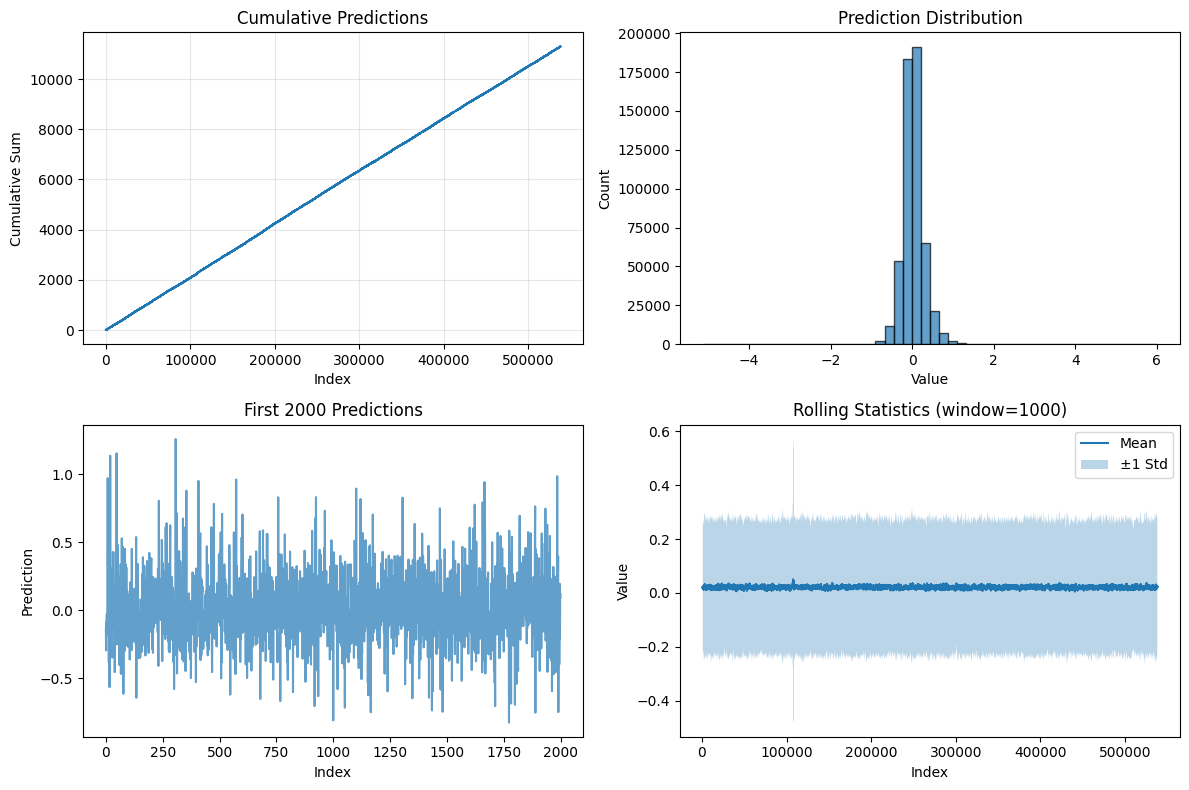

In [15]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Cumulative sum
axes[0, 0].plot(np.cumsum(y_pred))
axes[0, 0].set_title('Cumulative Predictions')
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Cumulative Sum')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(y_pred, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Prediction Distribution')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Count')

# First 2000 predictions
axes[1, 0].plot(y_pred[:2000], alpha=0.7)
axes[1, 0].set_title('First 2000 Predictions')
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Prediction')

# Rolling mean and std
window = 1000
rolling_mean = pred_series.rolling(window).mean()
rolling_std = pred_series.rolling(window).std()

axes[1, 1].plot(rolling_mean, label='Mean')
axes[1, 1].fill_between(
    range(len(rolling_mean)),
    rolling_mean - rolling_std,
    rolling_mean + rolling_std,
    alpha=0.3,
    label='±1 Std'
)
axes[1, 1].set_title(f'Rolling Statistics (window={window})')
axes[1, 1].set_xlabel('Index')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

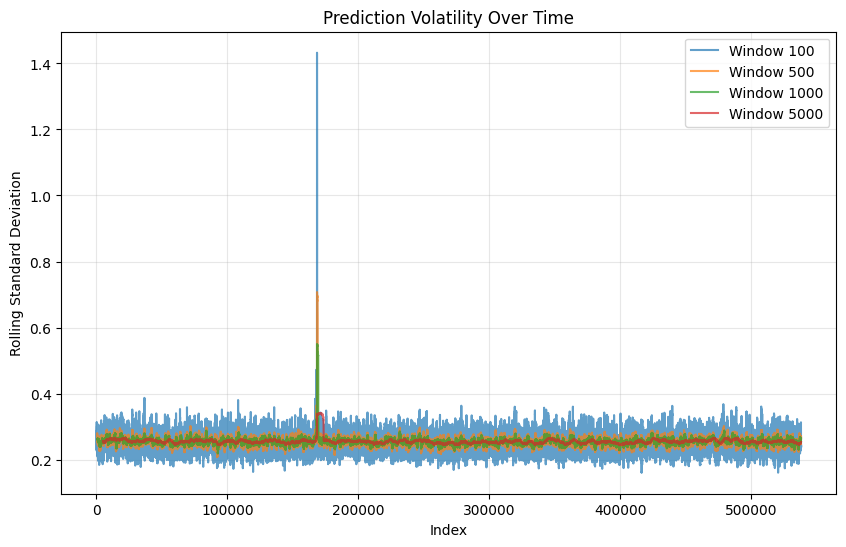

In [9]:
# Additional analysis plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Prediction volatility over time
window_sizes = [100, 500, 1000, 5000]
for window in window_sizes:
    rolling_vol = pred_series.rolling(window).std()
    ax.plot(rolling_vol, label=f'Window {window}', alpha=0.7)

ax.set_title('Prediction Volatility Over Time')
ax.set_xlabel('Index')
ax.set_ylabel('Rolling Standard Deviation')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

Prediction statistics

In [10]:
# Display submission info
print("\nSubmission preview:")
print(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Prediction range: [{submission['prediction'].min():.6f}, {submission['prediction'].max():.6f}]")
print(f"Mean: {submission['prediction'].mean():.6f}")
print(f"Std: {submission['prediction'].std():.6f}")

# Percentile information
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\nPrediction percentiles:")
for p in percentiles:
    value = np.percentile(submission['prediction'], p)
    print(f"  {p}th percentile: {value:.6f}")

print("\n" + "="*50)
print("PROCESS COMPLETED SUCCESSFULLY!")
print("="*50)

# Summary
print("\nModel Summary:")
print(f"- Total features used: {len(feature_cols)}")
print(f"- Feature batches: {len(feature_cols) // ensemble.feature_batch_size + 1}")
print(f"- Lag strategies (including odd/even): {len(ensemble.lag_strategies)}")
print(f"- Total models: {len(ensemble.models)}")
print(f"- Model type: SGDRegressor with warm start")
print(f"- Training: Incremental with partial_fit ({ensemble.n_epochs} epochs)")
print(f"- Prediction: Weighted ensemble average")

# Count total unique lag values
all_lags = set()
for lags in ensemble.lag_strategies.values():
    all_lags.update(lags)
print(f"- Total unique lag values: {len(all_lags)}")


Submission preview:
   ID  prediction
0   1   -0.120551
1   2   -0.167507
2   3    0.115678
3   4   -0.168663
4   5   -0.005353

Submission shape: (538150, 2)
Prediction range: [-5.217499, 6.295773]
Mean: 0.021053
Std: 0.255431

Prediction percentiles:
  1th percentile: -0.587739
  5th percentile: -0.366198
  10th percentile: -0.266229
  25th percentile: -0.126220
  50th percentile: 0.006584
  75th percentile: 0.150426
  90th percentile: 0.326545
  95th percentile: 0.465195
  99th percentile: 0.770205

PROCESS COMPLETED SUCCESSFULLY!

Model Summary:
- Total features used: 170
- Feature batches: 4
- Lag strategies (including odd/even): 25
- Total models: 100
- Model type: SGDRegressor with warm start
- Training: Incremental with partial_fit (9 epochs)
- Prediction: Weighted ensemble average
- Total unique lag values: 82


[TOC](#content)

In [ ]:
%watermark

Last updated: 2025-07-10T16:47:55.154475+08:00

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.31.0

Compiler    : MSC v.1938 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 20
Architecture: 64bit

